# Boosted Exponential Smoothing Volatility Forecasts

This notebook corresponds to the blog post [Extending Smooth Transitioning Exponential Smoothing Volatility Forecasts](https://steveya.github.io/2024/07/12/volatility-forecast-1.html). The aim is to replace the logistic function used by the STES model with a xgboost model, and evaluate their relative performance. It is a work in progress and will be updated as I wrap up my implementations.

In [1]:
import numpy as np
import pandas as pd
from functools import partial
from scipy.optimize import minimize, least_squares
from scipy.special import expit
from matplotlib import pyplot as plt
from operator import itemgetter
import yfinance as yf
import xgboost as xgb
import random

In [2]:
def simulate_contaminated_garch(n, mu, omega, alpha, beta, eta):
    returns = np.zeros(n)
    sigma2s = np.zeros(n)
    shocks = (np.random.uniform(0, 1, n) < 0.005).astype(float)
    for t in range(1, n):
        sigma2s[t] = omega + alpha * returns[t-1]**2 + beta * sigma2s[t-1]
        returns[t] = np.random.normal(mu, np.sqrt(sigma2s[t])) + eta * shocks[t]

    return returns, sigma2s

In [3]:
def stes_template(params, returns, features_func):
    assert len(params) == len(features_func)
    n = len(returns)
    sigma2s = np.zeros(n)
    alphas = np.zeros(n)
    for t in range(1, n):
        features = np.array([f(returns[t-1]) for f in features_func])
        alpha = expit(params @ features)
        alphas[t-1] = alpha
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2

    return sigma2s, alphas


In [4]:
const = lambda _: 1
abs_x = np.abs
sqr_x = lambda x: x**2
id_x = lambda x: x

In [5]:
es = partial(stes_template, features_func=(const,)) 
stes_ae = partial(stes_template, features_func=(const, abs_x))
stes_se = partial(stes_template, features_func=(const, sqr_x))
stes_eae = partial(stes_template, features_func=(const, abs_x, id_x))
stes_ese = partial(stes_template, features_func=(const, sqr_x, id_x))
stes_aese = partial(stes_template, features_func=(const, abs_x, sqr_x))

In [6]:
def squared_residual(params, model, returns, is_index=500, os_index=2000):
    sigma2s, _ = model(params, returns)
    sse = (returns ** 2 - sigma2s)
    residual = sse[is_index:os_index]
    return residual

def rmse_metric(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
    
    sse = (returns ** 2 - sigma2s) ** 2
    is_rmse = np.sqrt(np.mean(sse[is_index:os_index]))
    os_rmse = np.sqrt(np.mean(sse[os_index:]))
    return is_rmse, os_rmse, sigma2s, alphas

def nllh_metric(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
   
    llh = -np.log(sigma2s[2:]) - (returns[2:] ** 2 / sigma2s[2:])
    is_nllh = -np.sum(llh[is_index:os_index])
    os_nllh = -np.sum(llh[os_index:])
    return is_nllh, os_nllh, sigma2s, alphas

I tested two ways to optimize the parameters of the general stes model. The first is to directly compute the root mean squared error (RMSE) from `rmse_metric` function, take the first output `is_rmse`, and use  `scipy.optimize.minimize` to find the optimal parameters. The second is to compute the residuals from `squared_residual` and then use `scipy.optimize.least_squares` to find the optimal parameters. I initialize the initial parameters to the optimizer using a standard gaussian distribution. 

I found that the second method is more robust to parameters initialization. Below are the expeiment fitting the `stes_ae` model using the two approaches with 10 random initialization.

In [7]:
def fit_model_minimize(model, param_dim, returns, is_index=500, os_index=2000):
    initial_params = np.random.normal(0, 1, size=param_dim)
    obj_func_inner = lambda *args, **kwargs: itemgetter(0)(partial(rmse_metric, model)(*args, **kwargs))
    result = minimize(obj_func_inner, initial_params, args=(returns, is_index, os_index), method = 'SLSQP')
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    is_mse, os_mse, sigmas, alphas = rmse_metric(model,result.x, returns, is_index, os_index)
    is_llh, os_llh, _, _ = nllh_metric(model, result.x, returns, is_index, os_index)
    return (result.x, os_mse, os_llh, sigmas, alphas, is_mse, is_llh)

def fit_model_least_square(model, param_dim, returns, is_index=500, os_index=2000):
    initial_params = np.random.normal(0, 1, size=param_dim)
    obj_func_inner = partial(squared_residual, model=model, returns=returns, is_index=is_index, os_index=os_index)
    result = least_squares(obj_func_inner, initial_params)
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    is_mse, os_mse, sigmas, alphas = rmse_metric(model,result.x, returns, is_index, os_index)
    is_llh, os_llh, _, _ = nllh_metric(model, result.x, returns, is_index, os_index)
    return (result.x, os_mse, os_llh, sigmas, alphas, is_mse, is_llh)

fit_es_minimize = partial(fit_model_minimize, model=es, param_dim=1)
fit_stes_ae_minimize = partial(fit_model_minimize, model=stes_ae, param_dim=2)
fit_stes_se_minimize = partial(fit_model_minimize, model=stes_se, param_dim=2)
fit_stes_eae_minimize = partial(fit_model_minimize, model=stes_eae, param_dim=3)
fit_stes_ese_minimize = partial(fit_model_minimize, model=stes_ese, param_dim=3)
fit_stes_aese_minimize = partial(fit_model_minimize, model=stes_aese, param_dim=3)

fit_es_least_square = partial(fit_model_least_square, model=es, param_dim=1)
fit_stes_ae_least_square = partial(fit_model_least_square, model=stes_ae, param_dim=2)
fit_stes_se_least_square = partial(fit_model_least_square, model=stes_se, param_dim=2)
fit_stes_ese_least_square = partial(fit_model_least_square, model=stes_ese, param_dim=3)
fit_stes_eae_least_square = partial(fit_model_least_square, model=stes_eae, param_dim=3)
fit_stes_aese_least_square = partial(fit_model_least_square, model=stes_aese, param_dim=3)


Generate a random sample of returns.

In [8]:
np.random.seed(0)
np.random.seed(np.random.randint(0, 1e4, size=1))
simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)


In [9]:
np.random.seed(0)
for _ in range(10):
    lss = least_squares(partial(squared_residual, model=stes_ae, returns=simulated_garch_return), x0=np.random.normal(0, 1, 2)) 
    print(lss.x)

[-2.1670995  -0.11246057]
[-2.16702008 -0.11246866]
[-2.16714041 -0.11245641]
[-2.16711731 -0.11245876]
[-2.16701855 -0.11246882]
[-2.16712513 -0.11245797]
[-2.16697288 -0.11247378]
[-2.16716552 -0.11245386]
[-2.16707807 -0.11246275]
[-2.16712244 -0.11245824]


In [10]:
np.random.seed(0)
for _ in range(10):
    p, _, _, _, _, _, _ = fit_stes_ae_minimize(returns=simulated_garch_return)
    print(p)

[-2.16674593 -0.11249054]
[-11.80986301 -16.08684575]
[-2.1676799  -0.11233752]
[-2.1670345  -0.11249873]
[-2.16680262 -0.11192826]
[-2.16696151 -0.11245809]
[-2.1671567  -0.11248048]
[-2.16675334 -0.11247579]
[-2.16611258 -0.11210408]
[-2.16630593 -0.11304955]


Given exact same simualted sequence and random seeds used to gnerate the initial values to the optimizer, the `fit_stest_ae_minimize` function unstable optimas. After some playing around, the `fit_stest_ae_leastsquares` function seems to converge to a stable solution in repeated random runs.

### STES and ES Performance on Simulated Contaminated GARCH Data
I simulate the contaminated GARCH time series using the same parameters as in the Taylor (2020) paper. I then fit the STES and ES models to the simulated data and measure their performance on the test sample 1-step ahead root mean square forecast error. The results are shown in Table 1.

In [111]:
stes_ae_os_rmses = []
stes_se_os_rmses = []
es_os_rmses = []

num_runs = 1000
np.random.seed(0)
rand_seeds = np.random.randint(0, 1e6, size=num_runs)
for i in range(num_runs):
    np.random.seed(rand_seeds[i])
    simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)
    _, os_stes_se_rmse, _, _, _, _, _ = fit_stes_se_least_square(returns=simulated_garch_return)
    _, os_stes_ae_rmse, _, _, _, _, _ = fit_stes_ae_least_square(returns=simulated_garch_return)
    _,      os_es_rmse,      _, _, _, _, _ = fit_es_least_square(returns=simulated_garch_return)
    stes_ae_os_rmses.append(os_stes_ae_rmse)
    stes_se_os_rmses.append(os_stes_se_rmse)
    es_os_rmses.append(os_es_rmse)


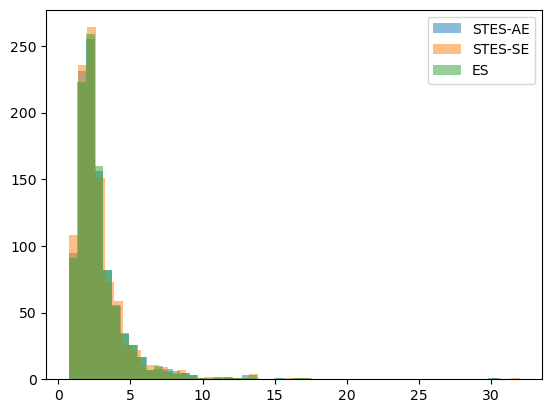

The mean of RMSE of the STES-AE model is 2.8452412258472464
The mean of RMSE of the STES-SE model is 2.8787248873818627
The mean of RMSE of the ES model is 2.85216396301645


In [112]:
plt.hist(stes_ae_os_rmses, bins=50, alpha=0.5, label='STES-AE')
plt.hist(stes_se_os_rmses, bins=50, alpha=0.5, label='STES-SE')
plt.hist(es_os_rmses, bins=50, alpha=0.5, label='ES')

plt.legend()
plt.show()

print(f"The mean of RMSE of the STES-AE model is {np.mean(stes_ae_os_rmses)}")
print(f"The mean of RMSE of the STES-SE model is {np.mean(stes_se_os_rmses)}")
print(f"The mean of RMSE of the ES model is {np.mean(es_os_rmses)}")


### Performace of STES and ES on SPY Variance Forecasts
I take the data from 2000 and fit the first 4000 data points (this part deviate from Taylor (2020), where they fit to data up to 2010.) My test-sample starts from 2015-11-27. I use record the average test-sample RMSE of 100 random initial parameters. 

In [90]:
spy_adj_close = yf.download("SPY", start="2000-01-01", end="2023-12-31")
spy_log_returns = np.log(spy_adj_close["Adj Close"]).diff().dropna() * 100

[*********************100%%**********************]  1 of 1 completed


In [12]:
print(f"SPY daily returns series has length {len(spy_log_returns)}")
print(f"Test data starts from {spy_log_returns.index[4000]}")

SPY daily returns series has length 6036
Test data starts from 2015-11-27 00:00:00


In [13]:
np.random.seed(0)
stes_aese_spy_res = [fit_stes_aese_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000) for _ in range(100)]

In [203]:
np.random.seed(0)
stes_eae_spy_res = [fit_stes_eae_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000) for _ in range(100)]

In [211]:
np.random.seed(0)
stes_ese_spy_res = [fit_stes_ese_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000) for _ in range(100)]

In [212]:
np.random.seed(0)
es_spy_res = [fit_es_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000) for _ in range(100)]

In [213]:
print(f"""
      STES AE&SE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_aese_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_aese_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_aese_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_aese_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_aese_spy_res]):.6f},
""")


      STES AE&SE Parameter Estimated on SPY Returns using MLE: [  -1.96844003   11.82339166 -161.83297896],  
      Out-of-Sample Mean Squared Error = 0.000450, 
      Out-of-Sample Neg Log-Likelihood = -17033.413527, 
      In-Sample Mean Squared Error = 0.000496,
      In-Sample Neg Log-Likelihood = -32546.811244,



In [217]:
print(f"""
      STES E&AE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_eae_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_eae_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_eae_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_eae_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_eae_spy_res]):.6f},
""")


      STES E&AE Parameter Estimated on SPY Returns using MLE: [-1.74754095 -9.24433279 -8.32852327],  
      Out-of-Sample Mean Squared Error = 0.000452, 
      Out-of-Sample Neg Log-Likelihood = -16975.620619, 
      In-Sample Mean Squared Error = 0.000495,
      In-Sample Neg Log-Likelihood = -32466.350112,



In [218]:
print(f"""
      STES E&SE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_ese_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_ese_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_ese_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_ese_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_ese_spy_res]):.6f},
""")


      STES E&SE Parameter Estimated on SPY Returns using MLE: [  -1.96981753 -334.44229617  -28.13900185],  
      Out-of-Sample Mean Squared Error = 0.000450, 
      Out-of-Sample Neg Log-Likelihood = -17019.445830, 
      In-Sample Mean Squared Error = 0.000493,
      In-Sample Neg Log-Likelihood = -32589.709564,



In [215]:
print(f"""
      ES Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in es_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in es_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in es_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in es_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in es_spy_res]):.6f},
""")


      ES Parameter Estimated on SPY Returns using MLE: [-2.19081635],  
      Out-of-Sample Mean Squared Error = 0.000464, 
      Out-of-Sample Neg Log-Likelihood = -17037.882879, 
      In-Sample Mean Squared Error = 0.000500,
      In-Sample Neg Log-Likelihood = -32581.415149,



## Building XGBoost-Based Exponential Smoothing Model

In [91]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform



In [92]:
class TimeSeriesDataIterator:
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.max_index = len(data) - window_size
        
    def __iter__(self):
        return self

    def __next__(self):
        if self.max_index < 0:
            raise StopIteration
            
        start_index = random.randint(0, self.max_index)
        end_index = start_index + self.window_size
        window_data = self.data[start_index:end_index]
        
        indices = list(range(start_index, end_index))
        return xgb.DMatrix(window_data.iloc[:, :-1], label=window_data.iloc[:, -1]), indices


class XGBoostExponentialSmoothing(BaseEstimator, RegressorMixin):
    def __init__(self, num_boost_round=100, ts_subsample=0.5, **xgb_params):
        self.xgb_params = xgb_params
        self.num_boost_round = num_boost_round
        self.ts_subsample = ts_subsample

        self.model = None
        
    def stes_variance_objective(self, preds, dtrain, indices=None):
        labels = dtrain.get_label()
        alphas = expit(preds)
        
        if indices is None:
            returns = self.data['returns'].to_numpy()
        else:
            returns = self.data.iloc[indices]['returns'].to_numpy()

        grads = np.zeros_like(preds)
        hesss = np.zeros_like(preds)
        varhs = np.zeros_like(preds)

        assert len(preds) == len(returns) == len(labels), "Mismatch between lengths of preds, returns, and labels"

        for t in range(len(returns)):
            if t == 0:
                lvar_f = np.var(returns)
                varhs[t] = alphas[t] * returns[t]**2 + (1 - alphas[t]) * lvar_f
                d_alpha = returns[t]**2 - lvar_f
            else:
                varhs[t] = alphas[t] * returns[t]**2 + (1 - alphas[t]) * varhs[t-1]
                d_alpha = returns[t]**2 - varhs[t-1]
            
            d_pred = alphas[t] * (1 - alphas[t]) * d_alpha
            grads[t] = 2 * (varhs[t] - labels[t]) * d_pred
            hesss[t] = 2 * d_pred**2

        return grads, hesss

    def fit(self, X, y=None):
        assert 'label' in X
        assert 'returns' in X
        
        self.data = X.copy()
        dtrain = xgb.DMatrix(X)
        
        iterator = TimeSeriesDataIterator(self.data, int(self.ts_subsample * len(X)))

        self.model = None
        for _ in range(self.num_boost_round):
            for ri, (dtrain, indices) in enumerate(iterator):
                if ri > 5:
                    break
                
                if self.model is None:
                    self.model = xgb.train(
                        self.xgb_params, dtrain, 
                        num_boost_round=5, 
                        obj=lambda preds, dtrain: self.stes_variance_objective(preds, dtrain, indices), 
                        evals=[(dtrain, 'train')], verbose_eval=False
                    )
                else:
                    self.model = xgb.train(
                        self.xgb_params, dtrain, 
                        num_boost_round=5, 
                        obj=lambda preds, dtrain: self.stes_variance_objective(preds, dtrain, indices), 
                        evals=[(dtrain, 'train')], 
                        xgb_model=self.model, verbose_eval=False
                    )
        
        if self.model is None:
            raise RuntimeError("Model training failed and no model was created.")
        
        return self.model

    def predict(self, X):
        if self.model is None:
            raise RuntimeError("You must train the model before predicting data!")
        
        if "label" in X:
            dtest = xgb.DMatrix(X.drop('label', axis=1))
        else:
            dtest = xgb.DMatrix(X)
        preds = self.model.predict(dtest)
        return preds

    def forecast_variance(self, X):
        alphas = expit(self.predict(X))
        
        returns = X['returns'].to_numpy()
        var_pred = np.zeros_like(alphas)
        var_pred[0] = returns[0]**2
        
        for t in range(1, len(returns)):
            var_pred[t] = alphas[t] * returns[t]**2 + (1 - alphas[t]) * var_pred[t-1]
        
        return var_pred

    def get_params(self, deep=True):
        """
        Return the parameters of the estimator.
        """
        return {
            "ts_subsample": self.ts_subsample, 
            'num_boost_round': self.num_boost_round, 
            **self.xgb_params
        }

    def set_params(self, **params):
        for key, value in params.items():
            if key in self.xgb_params:
                self.xgb_params[key] = value
            else:
                setattr(self, key, value)
        return self


In [93]:
xgb_params = {
    'max_depth': 3,            # Maximum depth of the tree
    'learning_rate': 0.1,      # Learning rate
    'num_boost_round': 100,    # Number of boosting rounds
    'colsample_bytree': 0.8,   # Column subsampling at tree level
    'colsample_bylevel': 0.8,  # Column subsampling at level level
    'colsample_bynode': 0.8,   # Column subsampling at node level
    'reg_lambda': 1.0,         # L2 regularization
    'random_state': 42,        # Seed for reproducibility
}

In [94]:
def xgb_stes_scoring_function(y_true, y_pred):
    """
    Custom scoring function that aligns with the custom objective function.
    """
    alphas = expit(y_pred)
    var_pred = np.zeros_like(alphas)
    y_true_np = y_true.to_numpy()
    var_pred[0] = y_true_np[0]**2  # Assuming y_true is returns for scoring

    for t in range(1, len(y_true)):
        var_pred[t] = alphas[t] * y_true_np[t-1] + (1 - alphas[t]) * var_pred[t-1]

    mse = np.mean((var_pred - y_true_np) ** 2)
    return -mse  # Negate the MSE because GridSearchCV maximizes the score

# Define a function to perform hyperparameter tuning
def tune_xgboost_model(X, y=None):
    param_dist = {
        'max_depth': randint(1, 5),
        'learning_rate': uniform(0.01, 0.19),
        'ts_subsample': uniform(),
        'reg_lambda': uniform(0.1, 10.0)
    }
    
    # Initialize the model
    model = XGBoostExponentialSmoothing()
    
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Use RandomizedSearchCV to find the best parameters
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        scoring=make_scorer(xgb_stes_scoring_function),
        cv=tscv,
        n_iter=50,  # Number of parameter settings that are sampled
        verbose=1,
        random_state=42,
        error_score='raise',
    )

    random_search.fit(X, y)
    
    return random_search.best_params_


In [110]:
xgb_stes_rmses = []
es_os_rmses = []

np.random.seed(0)
rand_seeds = np.random.randint(0, 1e6, size=10)
for i in range(10):
    np.random.seed(rand_seeds[i])
    simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)
    simulated_garch_feature_matrix = pd.DataFrame.from_dict({
        'returns': simulated_garch_return[:-1],
        'abs(returns)': np.abs(simulated_garch_return[:-1]),
        'returns^2': simulated_garch_return[:-1]**2,
        'label': simulated_garch_return[1:]**2,
    })
    
    xgb_es_model = XGBoostExponentialSmoothing(**xgb_params)
    xgb_es_model.fit(simulated_garch_feature_matrix.iloc[500:2000, :])

    xgb_es_predicted_garch_var_fs = xgb_es_model.forecast_variance(
        simulated_garch_feature_matrix.iloc[:, :-1]
    )
    os_xgb_es_rmse = np.sqrt(np.mean((xgb_es_predicted_garch_var_fs[-500:] - simulated_garch_feature_matrix.iloc[-500:, -1])**2))

    _, os_es_rmse, _, _, _, _, _ = fit_es_least_square(
        returns=simulated_garch_return
    )

    xgb_stes_rmses.append(os_xgb_es_rmse)
    es_os_rmses.append(os_es_rmse)


In [111]:
xgb_stes_rmses

[7.580650464157596,
 1.4840364695052803,
 2.0573728075183424,
 1.9516528570577154,
 2.153670437654188,
 3.480865804496944,
 1.975124788175122,
 3.2363359834362266,
 2.885783926917695,
 1.5973134223080971]

In [112]:
es_os_rmses

[6.942802813195433,
 1.1629124618185565,
 1.9029483679644152,
 1.7326920596926112,
 1.952208574462799,
 3.330179650524508,
 1.8271526835376872,
 3.012780974611026,
 2.575031933054428,
 1.4257287738495066]

In [114]:
spy_feature_matrix = pd.DataFrame.from_dict({
    'returns': spy_log_returns.to_numpy()[:-1],
    'abs(returns)': np.abs(spy_log_returns.to_numpy()[:-1]),
    'returns^2': spy_log_returns.to_numpy()[:-1]**2,
    'label': spy_log_returns.to_numpy()[1:]**2,
})

In [115]:
X = spy_feature_matrix.iloc[:4000]
y = spy_feature_matrix.iloc[:4000:, -1]

# Perform hyperparameter tuning
best_params = tune_xgboost_model(X, y)
print("Best Parameters:", best_params)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'learning_rate': 0.06629196608377566, 'max_depth': 1, 'reg_lambda': 0.8455064367977082, 'ts_subsample': 0.9868869366005173}


In [121]:
best_params_tuned = xgb_params | best_params
best_params_tuned


{'max_depth': 1,
 'learning_rate': 0.06629196608377566,
 'num_boost_round': 100,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 0.8,
 'colsample_bynode': 0.8,
 'reg_lambda': 0.8455064367977082,
 'random_state': 42,
 'ts_subsample': 0.9868869366005173}

In [122]:
xgb_stes_spy_model = XGBoostExponentialSmoothing(**best_params_tuned)
xgb_stes_spy_model.fit(spy_feature_matrix.iloc[:4000,:])


In [123]:
xgb_stes_spy_model.predict(spy_feature_matrix.iloc[:4000, :-1])

array([-2.1304412, -3.6255996, -5.6719337, ..., -6.2800193, -6.2800193,
       -6.2800193], dtype=float32)

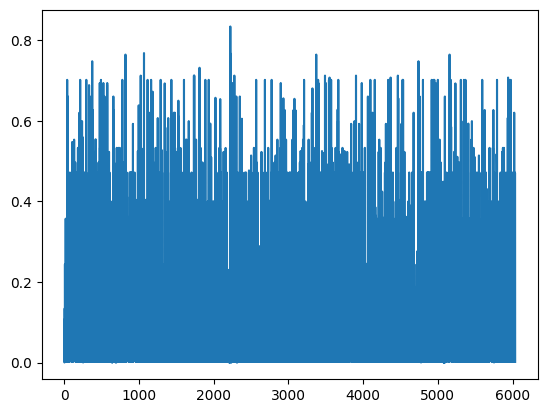

In [124]:
os_xgb_stes_spy_pred = expit(xgb_stes_spy_model.predict(spy_feature_matrix))
plt.plot(os_xgb_stes_spy_pred)

In [126]:
xgb_stes_predicted_spy_var_fs = xgb_stes_spy_model.forecast_variance(
    spy_feature_matrix
)

In [127]:
os_xgb_stes_spy_rmse = np.sqrt(np.mean((xgb_stes_predicted_spy_var_fs[4000:] - spy_log_returns[:-1][4000:].to_numpy()**2)**2))

_,        os_es_spy_rmse, _, _, _, _, _ = fit_es_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000)
_,  os_stes_eae_spy_rmse, _, _, _, _, _ = fit_stes_eae_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000)
_,  os_stes_ese_spy_rmse, _, _, _, _, _ = fit_stes_ese_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000)
_, os_stes_aese_spy_rmse, _, _, _, _, _ = fit_stes_aese_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000)

In [128]:
print(f"XGB STES SPY Error: {os_xgb_stes_spy_rmse}")
print(f"ES SPY Error: {os_es_spy_rmse}")
print(f"STES E&AE SPY Error: {os_stes_eae_spy_rmse}")
print(f"STES E&SE SPY Error: {os_stes_ese_spy_rmse}")
print(f"STES AE&SE SPY Error: {os_stes_aese_spy_rmse}")

XGB STES SPY Error: 4.287417170477376
ES SPY Error: 4.63983472238446
STES E&AE SPY Error: 4.520467608115644
STES E&SE SPY Error: 4.498323449171581
STES AE&SE SPY Error: 4.496550031690598
